# Jason Huffman
# Regis University - MSDS 696 Capstone Project
# COVID-19 Sentiment Analysis

## Summary of Project

This project was performed as a capstone requirement for the Regis University MSDS program.

The goal of this project was to perform a sentiment analysis on tweets from the Denver metro area related to the COVID-19 outbreak and CDC recommended best practices for containing the spread of COVID-19, such as practicing good hygiene, social distancing, and wearing masks. This information was used to create a sentiment score for the area that describes how positive or negative sentiments in the area were as a whole, toward a particular idea or policy each day.

Once the sentiment analysis was performed, the sentiment scores were compared to the number of COVID-19 cases per 100,000 individuals in the area and this was used to create a prediction model with the intent of predicting the infection rate.

The reason for doing this project was in hopes that sentiment changes displayed on social media might be able provide a bit of advanced notice that infection rates are about to change; this information could then be used by governments and health departments to proactively prepare for the change and adjust policies and marketing accordingly.

## Import Functions and Data

The data for this project was primarily pulled from Twitter to perform the sentiment analysis, and covid19.colorado.gov to obtain the daily county infection rate.  I gathered data spanning from March 17 - July 31 because March 17th was the first day that county data was available on Colorado's COVID-19 website.

I primarily used the statsmodels toolbox to create the model along with a number of other packages to perform various steps.  The first step in the process was to import all the required packages.

In [1]:
## Import Statements
import GetOldTweets3 as got
import csv
import pandas as pd
import numpy as np
import time
from glob import glob
import os
import io
import string
from nltk.tokenize import word_tokenize
import requests
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Scrape Twitter Data

I used the GetOldTweets3 python library to scrape Twitter data from the Denver metro area from mid-March through July.  I initially attempted to use Twitter's official API to pull tweets, but it has the limitation of not being able to access tweets older than a week.  Whereas, I wanted to pull data from the beginning of the coronavirus outbreak in Colorado, meaning I needed to pull data dating back to March 2020, so I searched for alternative methods of pulling data.  The GetOldTweets3 library essentially works by mimicking Twitter's browser search feature and scrolling through and storing the search results.  This library also has its limitations in that you cannot define the search area using a bounding box but rather must provide a center point coordinate and a radius, meaning every search must be a circular area making it difficult to search every corner of square geographic areas such as Colorado and its counties.

### Define Scraping Function
The GetOldTweets3 library allows you to set the same parameters that are available in Twitter's advanced browser search feature.  I chose to perform a search based on a geographic area (the Denver metro area), a specified date range (March 17 - July 31), and specific search terms (defined below).  GetOldTweets3 creates a Tweet model class that contains eleven parameters describing each tweet, including items such as retweets, favorites, mentions, and hashtags.  I chose to extract four of these variables, which were the tweet id, text, date, and geographic information.

```python
def get_tweets(date_since, date_until, search_term, max_tweets, near, within):
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(search_term)\
                                           .setSince(date_since)\
                                           .setUntil(date_until)\
                                           .setMaxTweets(max_tweets)\
                                           .setNear(near)\
                                           .setWithin(within)\
                                           .setLang('en')
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    for tweet in tweets:
        tweet_text = tweet.text.encode('utf-8', 'ignore')
        tweet_date = tweet.date
        tweet_id = tweet.id
        tweet_geo = tweet.geo
        csvWriter.writerow([tweet_id, tweet_text, tweet_date, tweet_geo])
```


### Define Variables

I created and iterated over a list of days pulling data and storing it after every day.  I did this so if the function timed out or encountered an error, I could restart the data pull where the error happened rather than having to start from the beginning.

``` python
idx = pd.date_range(start="2020-03-17",end="2020-07-31").date
idx2 = pd.date_range(start="2020-03-18",end="2020-08-01").date
starting_dates = pd.DataFrame({'date_since':idx})
ending_dates = pd.DataFrame({'date_until':idx2})
dates = starting_dates.merge(ending_dates, left_index = True, right_index=True)
```
I initially iterated through a list of center point coordinates and radii for each county in Colorado, but I eventually decided to focus on a single area, the Denver metro area.  While I set a value for the maximum number of tweets pulled, I never came close to reaching the maximum amount since I was only pulling one day at a time.  I estimated the center point coordinate and radius for the Denver metro area using Google Maps.  I decided that this estimate was good enough since I was able to capture the most populated areas and cities within the circle.

```python
# Greater Denver area radius
near = '39.747469,-104.872391'
within = '45mi'
max_tweets = 15000
# Colorado radius
# near = '38.99903,-105.5459'
# within = '190mi'
```

I then had to create a list of words to search for; I compiled this list using a couple different sources.  I first performed a general Twitter data pull consisting of a couple days' worth of tweets for the entire state of Colorado.  With this data I created a word cloud to visualize the terms that were commonly used.

![Word Cloud w/ COVID Terms Circled](exploratory_wordcloud_circled.png)

From the word cloud I saw that terms such as COVID, coronavirus, pandemic, and social distancing were used with some frequency during the couple day period.  Zooming in on the word cloud revealed a few more potentially related terms such as 'masks'.  The browser version of twitter also had a feature that allowed me to view popular hashtags, so I was able to pull some terms from hashtags that were being used at the time.  I also guessed at some possible terms and synonyms that might have been used for certain categories.  The combination of these methods gave me a few starting points to build the lists of search terms around.

In the end, the below lists are what I used; These lists could likely be further refined and more categories added to create a more complete search.

```python
masks = 'masks OR coverings OR face masks OR mask OR facemasks OR facemask OR ppe OR breathe'
social_distance = 'distance OR apart OR social distance OR isolation OR isolating OR socialdistancing OR stayathome OR lockdown OR stayhome OR staysafe'
hand_washing = 'wash hands OR wash OR washing OR sanitize OR santizing OR washyourhands OR handsanitizer OR disinfect OR santise OR clean'
coronavirus = 'coronavirus OR covid19 OR covid-19 OR covid OR pandemic OR virus'

search_grid = [masks, social_distance, hand_washing, coronavirus]
```

### Iterate Through Function w/ Search Variables

Finally, I iterated through the dates and search variables.  I initially saved each search term to its own csv file.  While it would have been more efficient to combine everything into a single file during the scraping process, I wanted the files separate in case I needed to go back and adjust the search terms for a single category later.  This allowed me to easily add and remove files as necessary.  When I started this project, I was pulling data for each county in Colorado individually; I ended up abandoning that effort and focused on the Denver metro area, but having separate files for each county and search term was beneficial in case I needed to add more data for a specific county or search term.

``` python
# Function to pull variable name for search terms to append to filename
def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
```

```python
# Iterate through each day
for index, row in dates.iterrows():
        date_since = str(row['date_since'])
        date_until = str(row['date_until'])
       
        # Iterate through each parameter in the search grid
        for i in search_grid:
                search_term = i
                name = namestr(search_term, globals())[0]

                filename = name + "_" +'Greater Denver Area County.csv'
                csvFile = open(filename, 'a', newline='')
                csvWriter = csv.writer(csvFile)
                get_tweets(date_since, date_until, search_term, max_tweets, near, within)
```


### Combine Files

Since I initially saved each search term in its own csv file, I needed to combine the files prior to performing a sentiment analysis and modeling.  I used the glob function to pull all .csv files created from scraping Twitter for this project from my computer.
```python
stock_files = sorted(glob("* County.csv"))
```

I then combined the files into a single ```combined_twitter_data``` data frame.
```python
dfList = []
for filename in stock_files:
    if os.stat(filename).st_size != 0:
        df = pd.read_csv(filename, header = None).assign(filename = filename)
        dfList.append(df)
combined_twitter_data = pd.concat(dfList, axis = 0).reset_index()
```

Next, I created a column for the search term used based on the filename, this made it possible to break out the sentiment score for each search term per day.
``` python
a = combined_twitter_data.filename.str[:4]
combined_twitter_data['search_term'] = np.where(a == 'hand', 'hygiene',
    np.where(a == 'mask', 'masks',
    np.where(a == 'soci', 'distancing',
    np.where(a == 'coro', 'coronavirus', 0))))
```

Finally, I organized the column headers and dropped unnecessary columns that were added in the merge process.
```python
combined_twitter_data.drop(combined_twitter_data.columns[[0, 4]], axis = 1, inplace = True)
combined_twitter_data.columns = ['id', 'tweet_text', 'date_time', 'filename', 'search_term']
```

## Perform Sentiment Analysis

After I had scraped and organized the Twitter data, I could perform a sentiment analysis on it.

### Process Tweet Text

The first step in performing the sentiment analysis was to process the text with the ultimate goal of splitting each tweet into individual component words.  In order to do this I had to standardize the text by converting the text to all lowercase, removing punctuation, and splitting into individual words.

In [2]:
# Read in Tweets
text = pd.read_csv("https://raw.githubusercontent.com/jhuffm/Huffman_MSDS-696_Project/master/data/combined_twitter_data.csv", index_col = 0)

# Convert to lower case
text['tweet_text'] = text['tweet_text'].str.lower()
# Remove punctuation
text['tweet_text'] = text['tweet_text'].str.translate(str.maketrans('','', string.punctuation))
# Remove first character since every tweet shows 'b' as the first character
text['tweet_text'] = text['tweet_text'].str[1:]
# Split tweets into individual words
text['tokenized_tweets'] = text.apply(lambda row: word_tokenize(row['tweet_text']), axis=1)

### Create Sentiment Dictionary

For this sentiment analysis I used the AFINN-165 word list, which is a tab separated text file containing 3,382 words and an associated sentiment score from -5 to 5 depending on how positive or negative the word is.  I iterated through the word list and created a dictionary consisting of word/score pairs.

In [3]:
scores_file = 'AFINN-165.txt'

# Loop through words in scores_file and store in dictionary
def readSentimentData(sentimentDataFile):
    sentimentfile = open(sentimentDataFile, "r")
    scores = {} 	
    for line in sentimentfile:
        word, score = line.split("\t")
        scores[word] = int(score) 
    sentimentfile.close()
    return scores	

scores = readSentimentData(scores_file)

### Loop through Tweets

I then looped through each word in each tweet and determined whether the word was in the AFINN-165 dictionary, if a word was in the dictionary its sentiment score was added to a list for that tweet.  I then took the average of the individual word scores for each tweet and saved it to a column called ```mean_score```.  The mean score will range from -5 to 5 for each tweet and told me on average how positive or negative a given tweet was.

In [4]:
text['mean_score'] = "" #Create empty column called mean_score to hold the average score for each tweet
i=0
# Loop through words in individual tweets to see if they contain words from the scores_file, produce the mean score for each tweet
for line in text['tokenized_tweets']:
    sentiments = {"-5": 0, "-4": 0, "-3": 0, "-2": 0, "-1": 0, "0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0}
    n=0
    for word in line:
        if word in scores.keys():
            score = scores[word]
            sentiments[str(score)] += 1
            n+=1
    if n > 0:
        text['mean_score'].loc[i] = 1/n*(sentiments["-5"]*-5+sentiments["-4"]*-4+sentiments["-3"]*-3+sentiments["-2"]*-2+sentiments["-1"]*-1+sentiments["0"]*0+sentiments["1"]*1+sentiments["2"]*2+sentiments["3"]*3+sentiments["4"]*4+sentiments["5"]*5)
    else:
        text['mean_score'].loc[i]=0
    i+=1

raw_sentiment_data = text.copy()
print(raw_sentiment_data.head())

                    id                                         tweet_text  \
0  1240064366784831488  this virus got me tripping about my blood fami...   
1  1240064265131675648             because coronavirus just wasnt enough    
2  1240064179563671552  good fuck you covid19 election2020 flprimary f...   
3  1240063606068305920  as we all know small local businesses are reel...   
4  1240063183651393541  seriously facebook finkd markzuckerberg  covid19    

                   date_time                                    filename  \
0  2020-03-17 23:55:58+00:00  coronavirus_Greater Denver Area County.csv   
1  2020-03-17 23:55:34+00:00  coronavirus_Greater Denver Area County.csv   
2  2020-03-17 23:55:14+00:00  coronavirus_Greater Denver Area County.csv   
3  2020-03-17 23:52:57+00:00  coronavirus_Greater Denver Area County.csv   
4  2020-03-17 23:51:16+00:00  coronavirus_Greater Denver Area County.csv   

   search_term                                   tokenized_tweets mean_score  
0

There were obviously a few limitations in performing a sentiment analysis using this method.  First, the method only considered the individual words in a tweet and did not take into account emojis, which are very popular and can provide context.  Second, by only considering the words individually, the method did not take into account the context surrounding the word was not able to differentiate things like sarcasm.  Finally, the sentiment scores in the AFINN-165 file are subjective to begin with and are rigid in their score, but in most actual cases the positivity of a word can vary greatly depending on how it is used.

## Organize Data for Modeling

After I performed the sentiment analysis, I had to merge data from multiple sources into a single dataframe and organize the data so that only the desired columns were kept.

### Format Sentiment Data

The first step in this process was to remove all columns from the sentiment data except for the ```date_time```, ```search_term```, and ```mean_score``` fields; this is because I no longer needed the actual text of the tweets, the ID number or the filename and these three fields were the only ones I was concerned with keeping for the analysis.  The sentiment data had multiple entries each day for each search term since multiple tweets were sent concerning the same topic each day.  For the analysis, I wanted a single score for the area each day, therefore, I took the average daily sentiment score for each search term.  Then, I needed to extract each search term into its own column, since I wanted the search terms to be unique variables for the model to analyze.  In order to do this, I pivoted the data on the search term columns.  The result of these steps gave me a dataset with 5 columns; the date and the corresponding sentiment score for each search term.

In [5]:
# Keep only the date, search term, and sentiment score columns
raw_sentiment_data = raw_sentiment_data[['date_time', 'search_term', 'mean_score']]
# Remove the time element from the date time field
raw_sentiment_data['date_time']= pd.to_datetime(raw_sentiment_data['date_time']).dt.date
# Take the average sentiment score for each day
raw_sentiment_data['mean_score'] = raw_sentiment_data['mean_score'].apply(pd.to_numeric)
raw_sentiment_data = raw_sentiment_data.groupby(['date_time', 'search_term'],as_index=False).mean()
# Pivot data to add seperate column for each search term
raw_sentiment_data = raw_sentiment_data.pivot(index = 'date_time', columns = 'search_term', values = 'mean_score')
print(raw_sentiment_data.head())

search_term  coronavirus  distancing   hygiene     masks
date_time                                               
2020-03-17     -0.241126    0.898611  0.500000 -0.557143
2020-03-18     -0.102880    0.953571  0.735714  0.187500
2020-03-19     -0.024343    0.776316 -0.166667 -0.406250
2020-03-20      0.011187    0.753968  0.637500  0.637963
2020-03-21     -0.018728    1.083951  0.119048  0.363636


### Format Colorado COVID-19 Data

The next step was to perform similar operations on the COVID-19 data extracted from Colorado's open data repository for COVID-19 found here: https://data-cdphe.opendata.arcgis.com/datasets/cdphe-covid19-county-level-open-data-repository/data.

I used a local copy saved to my GitHub repository in case the data collection methods changed or Colorado's repository moved.  I first extracted the rows corresponding to the seven counties that generally contain the greater Denver metro area; these counties were Adams, Arapahoe, Boulder, Broomfield, Denver, Douglas, and Jefferson.

In addition to case rate information, Colorado's repository included rows for things such as death counts, number of tests performed, and total case counts for a given county and day.  Therefore, I had to extract only the data for the daily case rates.  I then, removed columns that did not contribute to my model and kept just the ```Date``` and ```Rate``` columns.  Finally, I averaged the case rate across the 7 counties for each day so that I had a single daily case rate for the total Denver metro area.  My final dataset consisted of just two columns; the date and corresponding case rate.

In [6]:
## Import and organize County Data
county_covid_data = pd.read_csv("https://raw.githubusercontent.com/jhuffm/Huffman_MSDS-696_Project/master/data/CDPHE_COVID19_County-Level_Open_Data_Repository.csv")
# Keep only rows containing case rate and cases for Denver metro area counties
counties = ['Adams County', 'Arapahoe County', 'Boulder County', 'Broomfield County', 'Denver County', 'Douglas County', 'Jefferson County']
county_covid_data = county_covid_data[county_covid_data.values  == "Case Rates Per 100,000 People in Colorado by County"]
county_covid_data_filtered = pd.DataFrame()
for i in counties:
    temp = county_covid_data[county_covid_data.values  == i]
    county_covid_data_filtered = county_covid_data_filtered.append(temp)
# Keep only the date and case rate columns
county_covid_data_filtered = county_covid_data_filtered[['Rate', 'Date']]
# Convert Date field to a datetime object
county_covid_data_filtered['Date']= pd.to_datetime(county_covid_data['Date']).dt.date
# Take the mean case rate across the 7 counties for each day
county_covid_data_filtered = county_covid_data_filtered.groupby(['Date'],as_index = False).mean()
print(county_covid_data_filtered.head())

         Date      Rate
0  2020-03-17  3.000000
1  2020-03-18  3.516667
2  2020-03-19  4.316667
3  2020-03-20  5.042857
4  2020-03-21  6.885714


### Merging the Data

I finally had the two datasets properly formatted so that they could be merged on their respective date fields.

In [7]:
## Merge dataframes
merged_data = pd.merge(county_covid_data_filtered, raw_sentiment_data, left_on='Date',right_on='date_time', how='inner')
print(merged_data.head())

         Date      Rate  coronavirus  distancing   hygiene     masks
0  2020-03-17  3.000000    -0.241126    0.898611  0.500000 -0.557143
1  2020-03-18  3.516667    -0.102880    0.953571  0.735714  0.187500
2  2020-03-19  4.316667    -0.024343    0.776316 -0.166667 -0.406250
3  2020-03-20  5.042857     0.011187    0.753968  0.637500  0.637963
4  2020-03-21  6.885714    -0.018728    1.083951  0.119048  0.363636


## Explore Data

### Create a Moving Average

There was one final step I wanted to take in creating a dataset that was suitable for modeling, which was to smooth out the Twitter data a bit to remove the drastic fluctuations.  When I first examined the Twitter data, I noticed that the sentiment varied fairly wildly from day to day.

<div>
<img src="raw_sentiment_data.PNG" width="500"/>
</div>

This variation seemed to affect the accuracy of the model so I experimented with a couple techniques of creating a moving average to smooth out the data.  I experimented with both a simple moving average and an exponential moving average, ultimately decided to use an exponential moving average since it gives more weight to more recent observations, which I thought was appropriate in this instance.  I also experimented with different time spans to average the data over; the image below shows how the values changed for the coronavirus variable as I increased the time span to average over.

![Coronavirus Exponential Moving Average](covid_exp_moving_avg.PNG)

After some trial and error, I found that a limited amount of smoothing produced the best results; I ended up using a span of three days for the exponential moving average from which you can see that the extreme swings in values are smoothed out, but the data did not change very much.

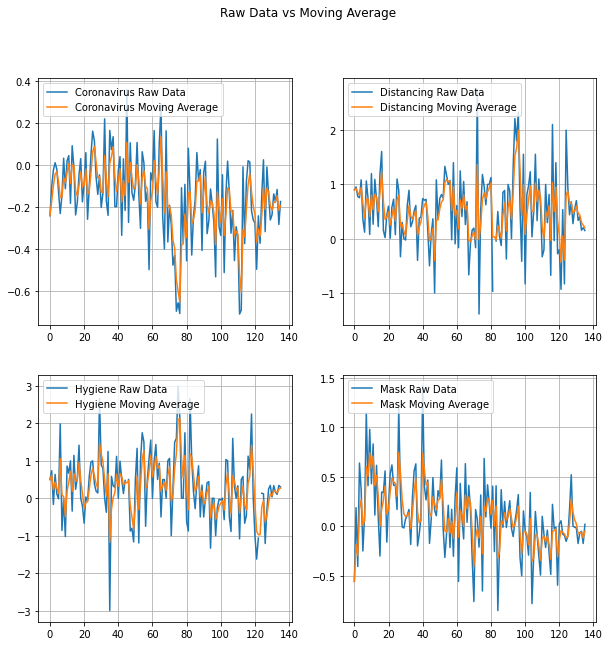

In [8]:
# Create a moving average of the twitter data using an exponential moving average
merged_data['coronavirus_EMA'] = merged_data['coronavirus'].ewm(span = 3, adjust=False).mean()
merged_data['distancing_EMA'] = merged_data['distancing'].ewm(span = 3, adjust=False).mean()
merged_data['hygiene_EMA'] = merged_data['hygiene'].ewm(span = 3, adjust=False).mean()
merged_data['masks_EMA'] = merged_data['masks'].ewm(span = 3, adjust=False).mean()

# Plot the original data against the moving average
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax[0,0].plot(merged_data['coronavirus'],label='Coronavirus Raw Data')
ax[0,0].plot(merged_data['coronavirus_EMA'],label='Coronavirus Moving Average')
ax[0,0].grid(True)
ax[0,0].legend(loc=2)
ax[0,1].plot(merged_data['distancing'],label='Distancing Raw Data')
ax[0,1].plot(merged_data['distancing_EMA'],label='Distancing Moving Average')
ax[0,1].grid(True)
ax[0,1].legend(loc=2)
ax[1,0].plot(merged_data['hygiene'],label='Hygiene Raw Data')
ax[1,0].plot(merged_data['hygiene_EMA'],label='Hygiene Moving Average')
ax[1,0].grid(True)
ax[1,0].legend(loc=2)
ax[1,1].plot(merged_data['masks'],label='Mask Raw Data')
ax[1,1].plot(merged_data['masks_EMA'],label='Mask Moving Average')
ax[1,1].grid(True)
ax[1,1].legend(loc=2)
plt.suptitle('Raw Data vs Moving Average')
plt.show()

# Drop the original columns and keep the moving average
merged_data.drop(merged_data.columns[[2,3,4,5]], axis = 1, inplace = True)

I also wanted to take a look at how the infection rate changed over time for the Denver metro area.

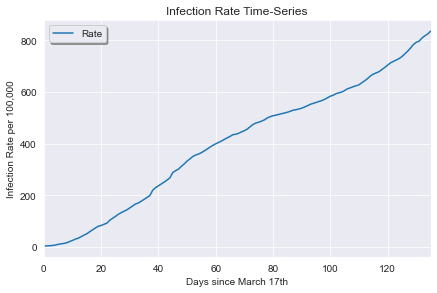

In [9]:
merged_data['Date'] = pd.to_datetime(merged_data.Date , format = '%Y-%m-%d')
data = merged_data.drop(['Date'], axis=1)
data.index = merged_data.Date

# Plotting Infection Rate
merged_data = merged_data.drop(['Date', 'coronavirus_EMA', 'distancing_EMA', 'hygiene_EMA', 'masks_EMA'], axis = 1)
sb.set_style('darkgrid')
merged_data.plot(kind = 'line', legend = 'reverse', title = 'Infection Rate Time-Series')
plt.legend(loc = 2, shadow = True)
plt.tight_layout()
plt.xlabel('Days since March 17th')
plt.ylabel('Infection Rate per 100,000')
plt.show()

The plot above showed me that the infection rate for the Denver area has been on a relatively constant climb since the beginning of the pandemic.

## Create Model

With the data fully merged and explored I was ready to build a predictive model.  With the data being a multivariate time series, I chose to use a vector autoregression (VAR) model because it was able to capture interdependencies among the multiple variables in the time series.  However, in order to create the model, I first had to perform a number of checks and tests.

### Check for Missing Data

I first checked for any missing data in the dataset and found that there was none.  If there had been missing values, I would have needed to impute the missing values, likely by using the preceding value to fill in the missing value.

In [10]:
# check for missing values
print(data.isnull().sum())

Rate               0
coronavirus_EMA    0
distancing_EMA     0
hygiene_EMA        0
masks_EMA          0
dtype: int64


### Test for Causality

The next pre-modeling step was to test for causality; in order to do this, I used the Granger causality test.  I pulled the code for this test from this article:
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

The output of this test showed the p-value for the null hypothesis that the column property does not cause the row property.  So, a p-value less than 0.05 meant I could reject the null hypothesis and conclude that the column property caused the row property.  The basis of VAR is that variables have an effect on each other so this directional correlation is important for an accurate model.

In [11]:
# Test for Causality using Granger causality test
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

print(grangers_causation_matrix(data, variables = data.columns))

                   Rate_x  coronavirus_EMA_x  distancing_EMA_x  hygiene_EMA_x  \
Rate_y             1.0000             0.0036            0.0072         0.0010   
coronavirus_EMA_y  0.0033             1.0000            0.3464         0.1558   
distancing_EMA_y   0.2342             0.1915            1.0000         0.3762   
hygiene_EMA_y      0.2499             0.4029            0.7874         1.0000   
masks_EMA_y        0.0000             0.0832            0.0408         0.2213   

                   masks_EMA_x  
Rate_y                  0.0196  
coronavirus_EMA_y       0.0046  
distancing_EMA_y        0.4473  
hygiene_EMA_y           0.1439  
masks_EMA_y             1.0000  


The results of the causality test showed that the Rate is likely caused in part by every variable aside from masks.  Because of this, I initially dropped the masks variable out of the model, but the model turned out to perform better with the variable included so I ultimately added it back.

### Check for Stationarity

Another test that needed to be performed was a check for stationarity.  Stationarity refers to the degree to which the properties of a time series are dependent on the time at which the series is observed.  The properties of a stationary time series do not depend on the time of observation.  Things such as trends and seasonality cause a time series to not be stationary and can negatively affect the model.

I first split the data into a test and training dataset and then checked for stationarity using the Augmented Dickey-Fuller Test.  For the data split I took the first 80% of the data and used it for training, and tested with the remaining 20%.  Since this was a time series, the data needed to be continuous for the test and training sets rather than random.

In [12]:
# Split Data into training and validation dataset
# For time series we want to use continuous portions of the dataset rather than pulling a random 80% for training
nobs = 28
training_data = data[:int(0.8*(len(data)))]
validation_data = data[int(0.8*(len(data))):]

# Check for Stationarity using the Augmented Dickey-Fuller Test
def adf_test(series, signif=0.05, name = ''):
    dftest = adfuller(series, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['test_statistic','pvalue','n_Lags','n_obs'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print (adf)
    p = adf['pvalue']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

# Apply adf test on the series
for name, column in training_data.iteritems():
    adf_test(column, name = column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Rate" 
    -----------------------------------------------
test_statistic          -2.533245
pvalue                   0.107594
n_Lags                   8.000000
n_obs                   99.000000
Critical Value (1%)     -3.498198
Critical Value (5%)     -2.891208
Critical Value (10%)    -2.582596
dtype: float64
 Series is Non-Stationary


    Augmented Dickey-Fuller Test on "coronavirus_EMA" 
    -----------------------------------------------
test_statistic           -3.439562
pvalue                    0.009682
n_Lags                    1.000000
n_obs                   106.000000
Critical Value (1%)      -3.493602
Critical Value (5%)      -2.889217
Critical Value (10%)     -2.581533
dtype: float64
 Series is Stationary


    Augmented Dickey-Fuller Test on "distancing_EMA" 
    -----------------------------------------------
test_statistic         -5.786067e+00
pvalue                  4.996200e-07
n_Lags                  0.000000e+00
n_obs          

The above output showed that the Rate and Mask variables were not initially stationary.

#### Take First Difference

Since every series was not initially stationary, I attempted to make the series stationary by taking the first difference and rechecking for stationarity.  Differencing computes the difference between consecutive observations in an attempt to make the data stationary.

In [13]:
# Make all series stationary if necessary by taking first difference
df_differenced = training_data.diff().dropna()
for name, column in df_differenced.iteritems():
    adf_test(column, name = column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Rate" 
    -----------------------------------------------
test_statistic          -2.070892
pvalue                   0.256379
n_Lags                   7.000000
n_obs                   99.000000
Critical Value (1%)     -3.498198
Critical Value (5%)     -2.891208
Critical Value (10%)    -2.582596
dtype: float64
 Series is Non-Stationary


    Augmented Dickey-Fuller Test on "coronavirus_EMA" 
    -----------------------------------------------
test_statistic         -8.479673e+00
pvalue                  1.404198e-13
n_Lags                  2.000000e+00
n_obs                   1.040000e+02
Critical Value (1%)    -3.494850e+00
Critical Value (5%)    -2.889758e+00
Critical Value (10%)   -2.581822e+00
dtype: float64
 Series is Stationary


    Augmented Dickey-Fuller Test on "distancing_EMA" 
    -----------------------------------------------
test_statistic          -4.858358
pvalue                   0.000042
n_Lags                  10.000000
n_obs     

#### Take Second Difference

After taking the first difference, the Rate was still not stationary so I took a second difference of the series.

In [14]:
# If still not stationary, take second difference
df_differenced = df_differenced.diff().dropna()
for name, column in df_differenced.iteritems():
    adf_test(column, name = column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Rate" 
    -----------------------------------------------
test_statistic          -5.305631
pvalue                   0.000005
n_Lags                   6.000000
n_obs                   99.000000
Critical Value (1%)     -3.498198
Critical Value (5%)     -2.891208
Critical Value (10%)    -2.582596
dtype: float64
 Series is Stationary


    Augmented Dickey-Fuller Test on "coronavirus_EMA" 
    -----------------------------------------------
test_statistic         -8.677656e+00
pvalue                  4.371788e-14
n_Lags                  4.000000e+00
n_obs                   1.010000e+02
Critical Value (1%)    -3.496818e+00
Critical Value (5%)    -2.890611e+00
Critical Value (10%)   -2.582277e+00
dtype: float64
 Series is Stationary


    Augmented Dickey-Fuller Test on "distancing_EMA" 
    -----------------------------------------------
test_statistic          -5.116822
pvalue                   0.000013
n_Lags                  10.000000
n_obs         

After the second difference, every series was stationary, so I could begin to create the model.

### Create Model

The actual model creation was straightforward and I used the VAR function from the statsmodels package.

In [15]:
# create and fit a model
model = VAR(df_differenced)
results = model.fit(maxlags=15, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Aug, 2020
Time:                     20:11:41
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                  -0.668155
Nobs:                     91.0000    HQIC:                  -6.92306
Log likelihood:           241.847    FPE:                0.000578546
AIC:                     -11.1531    Det(Omega_mle):     2.77947e-05
--------------------------------------------------------------------
Results for equation Rate
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.041311         0.263564           -0.157           0.875
L1.Rate                    -0.339251         0.248459           -1.365           0.172
L1.coronavirus_EMA          5.436172 

### Forecast Using Model

In order to forecast with the model, I simply used the forecast method, which generated a forecast for each variable for 28 days which was the 20% of dates used for testing.

In [16]:
# Forecast using model
# Get the lag order
lag_order = results.k_ar
print(lag_order)

# Input data for forecasting
fc = results.forecast(df_differenced.values[-lag_order:], steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + '_2d')
print(df_forecast)

15
              Rate_2d  coronavirus_EMA_2d  distancing_EMA_2d  hygiene_EMA_2d  \
Date                                                                           
2020-07-04   0.165157            0.232354          -0.783756       -2.595829   
2020-07-05  10.353928           -0.447418           2.091633        1.930313   
2020-07-06 -12.855400            0.153672          -0.859818       -0.102492   
2020-07-07   6.570775            0.280941          -0.565840       -2.248989   
2020-07-08   2.100158           -0.165712           1.022300        2.800786   
2020-07-09  -1.615401           -0.677139           0.141141       -0.438639   
2020-07-10  -4.900483            0.821431          -2.309015        0.308339   
2020-07-11   1.733564           -0.078929           2.696197       -0.979496   
2020-07-12   7.453928           -0.247359          -0.553994        0.570492   
2020-07-13  -9.995792           -0.065895          -1.956406        1.447116   
2020-07-14   7.211616            0.72

It was clear from the above output that this was not the actual forecast of the rate of infection for each day; instead, this was the forecast for the second difference of the variables.  In order to get the actual forecasted values, I had to reverse the effect of taking the difference twice.

In [17]:
# Invert model to undo effect of differencing earlier
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# Display non-inverted predictions
df_results = invert_transformation(training_data, df_forecast, second_diff=True)
print(df_results.loc[:, ['Rate_forecast']])

            Rate_forecast
Date                     
2020-07-04     619.679443
2020-07-05     633.727099
2020-07-06     634.919356
2020-07-07     642.682387
2020-07-08     652.545576
2020-07-09     660.793364
2020-07-10     664.140670
2020-07-11     669.221540
2020-07-12     681.756338
2020-07-13     684.295343
2020-07-14     694.045964
2020-07-15     707.439520
2020-07-16     707.925818
2020-07-17     716.738170
2020-07-18     724.310351
2020-07-19     731.621882
2020-07-20     737.497073
2020-07-21     746.248181
2020-07-22     757.501233
2020-07-23     755.789725
2020-07-24     767.175610
2020-07-25     778.546007
2020-07-26     782.109727
2020-07-27     793.231982
2020-07-28     799.725493
2020-07-29     810.305510
2020-07-30     812.169244
2020-07-31     826.050220


After reversing the effects of taking two differences, the results looked much more like what we would expect the case rates to be for the month of July.

### Evaluate Model Performance

Finally, I evaluated the performance of the model by both visualizing graphically how the model performed compared to the actual case rates as well as calculating a number of metrics such as the mean absolute error, the mean squared error, and the root mean squared error.

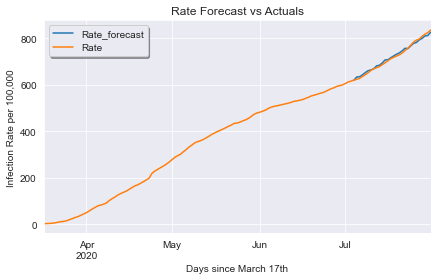

Forecast Accuracy
MAE = 6.841777
MSE = 57.542330
RMSE = 7.585666


In [18]:
# Plot predictions vs actuals
sb.set_style('darkgrid')
df_results['Rate_forecast'].plot()
data["Rate"].plot()
plt.title(label = 'Rate Forecast vs Actuals')
plt.legend(loc = 2, shadow = True)
plt.tight_layout()
plt.xlabel('Days since March 17th')
plt.ylabel('Infection Rate per 100,000')
plt.show()

expected = validation_data['Rate']
predicted = df_results['Rate_forecast'].values

mae = mean_absolute_error(expected, predicted)
mse = mean_squared_error(expected, predicted)
rmse = sqrt(mse)
print('Forecast Accuracy')
print('MAE = %f'% mae)
print('MSE = %f'% mse)
print('RMSE = %f'% rmse)

The graph above appeared to show a very good prediction when compared with the actual infection rate for the month of July.  The accuracy statistics also showed that the model was fairly accurate for this time frame with a mean absolute error of about 7 cases each day or somewhere around 1-2 percent error on average.

## Constraints of Model

Despite the apparent accuracy of the model, it is likely that some overfitting is occurring, which would make the model less valuable for other predictions.  It also appears that a simple linear regression model would perform relatively well with the current data since the case rate had been consistently increasing for the most part.  Also, I am not confident that if the case rate were to quickly change, the current model would be able to accurately predict the change.

The model in its current form has many constraints that would likely contribute to its inability to actually be predictive or to be useful in other geographic areas; this includes items such as:

- Twitter is likely not representative of the entire population
- It is difficult to capture sentiment in sparsely populated and rural areas
- The geographic definition for pulling Twitter data was not precise since it is a center point and radius

## Future Efforts

There are a number of things that I would like to explore to see if I can improve the robustness of the model so that it can better predict sudden changes and be used across a wider range of geographic areas.  One way I would like to do that is to pull more data; for this project I wanted to focus my efforts specifically on Twitter sentiments but pulling data from additional social media sources and performing a sentiment analysis on that would provide a larger set of data, which could help address the sparseness of data in rural areas.  Pulling more categories worth of data could also help remedy the lack of widespread data.  Also, I would like to address ways to make the sentiment analysis itself more effective such as including emoji sentiments and trying to recognize context.  One final tweak I would like to explore is to be more exact with the defined geographic areas I pulled data for, that way the sentiment data area would more closely match the COVID data area.


## Resources

Alam, M. (2020, April 04). Multivariate time series forecasting. Retrieved from https://towardsdatascience.com/multivariate-time-series-forecasting-653372b3db36

Anala, S. (2020, May 20). Simple Multivariate Time-Series Forecasting. Retrieved from https://towardsdatascience.com/simple-multivariate-time-series-forecasting-7fa0e05579b2

[buildwithpython]. (2020, March 14). Sentiment Analysis Python - 8 - Twitter Emotion Analysis using GetOldTweets3 [Video]. YouTube. https://www.youtube.com/watch?v=yufg9PdxrWs

[buildwithpython]. (2020, March 4). Sentiment Analysis Python - 4 - Tokenization and Stop Words (NLP) [Video]. YouTube. https://www.youtube.com/watch?v=KrEhmADXTr8

CDPHE COVID19 County-Level Open Data Repository. (n.d.). Retrieved from https://data-cdphe.opendata.arcgis.com/datasets/cdphe-covid19-county-level-open-data-repository/data

Hsu, S. (2018, September 10). Introduction to Data Science: Custom Twitter Word Clouds. Retrieved from https://medium.com/@shsu14/introduction-to-data-science-custom-twitter-word-clouds-704ec5538f46

Killary, K. (2018, March 10). Elegantly Reading Multiple CSVs Into Pandas. Retrieved from https://medium.com/@kadek/elegantly-reading-multiple-csvs-into-pandas-e1a76843b688

Maitra, S. (2019, October 07). Time Series Analysis using Granger's Causality and VAR Model: An example with Python code. Retrieved from https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

Prabhakaran, S. (2020, April 27). Vector Autoregression (VAR) - Comprehensive Guide with Examples in Python. Retrieved from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

[PythonHow]. (2015, July 29). How to concatenate multiple CSV files in one single CSV with Python [Video]. YouTube. https://www.youtube.com/watch?v=KoRT-v0SzMs

Rovai, M. (2018, December 27). (Almost) Real-Time Twitter Sentiment Analysis with Tweep & Vader. Retrieved from https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c
